# NOTE ABOUT ADJUSTMENT:

Did a run with just two magnitude bins to see the difference.

# New Sampling Method:

This pipeline will begin with defining a new sampling method to hopefully alleviate the issue of implicitly assuming a detection rate. Working with the same area of sky as previous methods, the new sampling method would essentially just ask what pixels to throw the stream in, and what excess percent to inject there. To avoid any assumptions on detection rate throwing off number of detected objects, to start 100% of the desired objects will be injected, although we will make sure to take relative detection rates into account. However, we will stop at the exact number of desired stars, allowing for no variation. Next, as an example lets assume the desired excess in the stream is 25%. In this case, the above will be done again exactly, just stopping at 25% of the object counts instead of 100%. This will be done ON THE FULL SKY. After this, we will crop this excess to just the stream. This is not the most efficient way possible to do this, but it avoids the issue of implicit detection rate assumptions and the issue of potentially always having the same number of objects in the stream.

# Next Time:

Inject structure via survey properties, keep stream uniform (similar to current methods). Inject power as sin wave fluctuation with wavelength similar to DES cam footprint size and see if we see a spike in power removed via corrections.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style
import matplotlib
matplotlib.style.use('des_dr1')
import fitsio
import healpy as hp
import healsparse as hsp
import skyproj
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from scipy.stats import linregress
from scipy.signal import welch
from astropy.table import Table

## Data for Each Test

In [2]:
total_pixels = 2304
# Extra Length Test
total_pixels = 6912

center_ra, center_dec = 30, -35
center_pix = hp.ang2pix(32, center_ra, center_dec, lonlat = True, nest = True)

pixels = np.append(hp.pixelfunc.get_all_neighbours(32, center_pix, nest=True), center_pix)
pix32 = np.zeros(12*(32**2))
pix32[pixels] = 1

pix512 = np.where(hp.ud_grade(pix32, 512, order_in = 'NESTED', order_out = 'NESTED') > 0)[0]

# Extra Length Test

center_pix = []
center_pix.append(hp.ang2pix(32, center_ra, center_dec, lonlat = True, nest = True))
center_pix.append(hp.pixelfunc.get_all_neighbours(32, center_pix[0], nest=True)[0])
center_pix.append(hp.pixelfunc.get_all_neighbours(32, center_pix[-1], nest=True)[0])
center_pix.append(hp.pixelfunc.get_all_neighbours(32, center_pix[-1], nest=True)[0])
center_pix.append(hp.pixelfunc.get_all_neighbours(32, center_pix[0], nest=True)[4])
center_pix.append(hp.pixelfunc.get_all_neighbours(32, center_pix[-1], nest=True)[4])
center_pix.append(hp.pixelfunc.get_all_neighbours(32, center_pix[-1], nest=True)[4])
center_pix = np.array(center_pix)

pixels = np.unique(np.append(hp.pixelfunc.get_all_neighbours(32, center_pix, nest=True).flatten(), center_pix))
pix32 = np.zeros(12*(32**2))
pix32[pixels] = 1

pix512 = np.where(hp.ud_grade(pix32, 512, order_in = 'NESTED', order_out = 'NESTED') > 0)[0]

variedStream = [hp.ang2pix(32, center_ra, center_dec, lonlat = True, nest = True)]
for _ in np.arange(4):
    variedStream.append(hp.pixelfunc.get_all_neighbours(32, variedStream[-1], nest=True)[0])
variedStream.append(hp.pixelfunc.get_all_neighbours(32, variedStream[0], nest=True)[4])
for _ in np.arange(3):
    variedStream.append(hp.pixelfunc.get_all_neighbours(32, variedStream[-1], nest=True)[4])
variedStream = np.array(variedStream)
variedStream = variedStream[np.array([0, 2, 4, 6, 8])]

variedPix32 = np.zeros(12*(32**2))
variedPix32[variedStream] = 1

variedPix512 = np.where(hp.ud_grade(variedPix32, 512, order_in = 'NESTED', order_out = 'NESTED') > 0)[0]

# Adjustments from here on, switching from 3 to 2

In [3]:
# # Total Counts for these Object Types
# tot_SaS = np.array([7311, 4593, 6853])
# tot_SaG = np.array([569, 2788, 5714])
# tot_GaS = np.array([2309, 10519, 15653])
# tot_GaG = np.array([85553, 264701, 177192])

# Extra Length Test, also extra bin
extraBinPer = 0
tot_SaS = np.array([22256, 14216, 20910, int(extraBinPer * 6866)])
tot_SaG = np.array([1767, 8502, 17465, int(extraBinPer * 5735)])
tot_GaS = np.array([7041, 31231, 46363, int(extraBinPer * 165401)])
tot_GaG = np.array([251617, 791138, 532102, int(extraBinPer * 1898281)])

In [4]:
# Get Data
algoCompDir = '/hdfs/bechtol/balrog/y3/y3a2_survey_conditions_maps/Kyle_Stuff/MaximumLikelihood/FinalPipeline/Tests/Algorithm_Comparison/'
algoCompFile = algoCompDir + 'Center_RA30_DEC-35.fits'
# Extra Length Test
algoCompFile = algoCompDir + 'Extra_Length_Center_RA30_DEC-35.fits'

In [5]:
orig_data = fitsio.read(algoCompFile)

orig_star_as_star = []
orig_star_as_gala = []
orig_gala_as_star = []
orig_gala_as_gala = []

orig_star_corr = []
orig_gala_corr = []

for i in np.arange(3):
    orig_star_as_star.append(orig_data['Star_as_Star_Bin_' + str(i + 1)])
    orig_star_as_gala.append(orig_data['Star_as_Gala_Bin_' + str(i + 1)])
    orig_gala_as_star.append(orig_data['Gala_as_Star_Bin_' + str(i + 1)])
    orig_gala_as_gala.append(orig_data['Gala_as_Gala_Bin_' + str(i + 1)])
    
    orig_star_corr.append(orig_data['Star_Corr_Bin_' + str(i + 1)])
    orig_gala_corr.append(orig_data['Gala_Corr_Bin_' + str(i + 1)])
    
# Extra mag bin test
orig_star_as_star.append(orig_data['Star_as_Star_Bin_' + str(i + 1)])
orig_star_as_gala.append(orig_data['Star_as_Gala_Bin_' + str(i + 1)])
orig_gala_as_star.append(orig_data['Gala_as_Star_Bin_' + str(i + 1)])
orig_gala_as_gala.append(orig_data['Gala_as_Gala_Bin_' + str(i + 1)])

orig_star_corr.append(orig_data['Star_Corr_Bin_' + str(i + 1)])
orig_gala_corr.append(orig_data['Gala_Corr_Bin_' + str(i + 1)])

orig_pix = orig_data['PIX']

In [6]:
# Notation: SaS = star as star relative rates
SaS = np.ones((4, len(pix512)))
SaG = np.ones((4, len(pix512)))
GaS = np.ones((4, len(pix512)))
GaG = np.ones((4, len(pix512)))

# Correct classification probabilities
PS = np.ones((4, len(pix512)))
PG = np.ones((4, len(pix512)))

for i in np.arange(4):
    PS[i] = PS[i] * np.average(orig_star_corr[i])
    PG[i] = PG[i] * np.average(orig_gala_corr[i])

In [7]:
matchInds = np.isin(pix512, orig_pix)

In [8]:
for i in np.arange(4):
    SaS[i][matchInds] = orig_star_as_star[i]
    SaG[i][matchInds] = orig_star_as_gala[i]
    GaS[i][matchInds] = orig_gala_as_star[i]
    GaG[i][matchInds] = orig_gala_as_gala[i]
    
    PS[i][matchInds] = orig_star_corr[i]
    PG[i][matchInds] = orig_gala_corr[i]

In [9]:
def sample(probMap, perTotal, totCount, totPix = total_pixels):
    retCount = int(totCount * perTotal)
    retPixRepeats = np.array([])
    while(len(retPixRepeats) < retCount):
        testPix = np.random.choice(totPix, retCount)
        probs = np.max(probMap) * np.random.rand(retCount)
        retPixRepeats = np.append(retPixRepeats, testPix[np.where(probs < probMap[testPix])[0]])
    np.random.shuffle(retPixRepeats)
    if len(retPixRepeats) > retCount:
        retPixRepeats = retPixRepeats[0:retCount]

    _, retPix = np.unique(np.append(np.arange(totPix), retPixRepeats), return_counts = True)
    return (retPix - 1)

## One-D Dependencies

First plot to go in the paper, look at the one dimensional dependencies of stream counts on the different relative detection rate probabilities.

This test is probably the most obvious in terms of 

In [10]:
# These stream pixels will just be the first ordered 230.
# Structure doesn't matter much before the power spectrum test.
stream_pixels = 230

binNum = 10

condMaps = []
for i in np.arange(3):
    condMaps.append(SaS[i][:stream_pixels])
for i in np.arange(3):
    condMaps.append(SaG[i][:stream_pixels])
for i in np.arange(3):
    condMaps.append(GaS[i][:stream_pixels])
for i in np.arange(3):
    condMaps.append(GaG[i][:stream_pixels])
condMaps = np.array(condMaps)

sortInds = []
for i in range(len(condMaps)):
    sortInds.append(condMaps[i].argsort())
sortInds = np.array(sortInds)

binIndLims = [0]

for i in range(binNum):
    binIndLims.append(int((len(condMaps[0]) - binIndLims[-1]) / (binNum - i)) + (binIndLims[-1]))
    
xBins = []

for i in range(len(condMaps)):
    cond_Map_Sort = condMaps[i][sortInds[i][::1]]
    condBins = []
    for j in range(binNum):
        condBins.append(cond_Map_Sort[binIndLims[j]:binIndLims[j+1]])
    indXBin = []

    for j in range(binNum):
        indXBin.append(np.sum(condBins[j]) / len(condBins[j]))

    xBins.append(np.array(indXBin))

xBins = np.array(xBins)

In [11]:
numReals = 5000
streamExcess = 0.25

# These are with variable properties before corrections
var_obs = np.zeros((numReals, total_pixels))
var_cla = np.zeros((numReals, total_pixels))

# These are recovered counts, obs is current algo, cla is other algo
rec_obs = np.zeros((numReals, total_pixels))
rec_cla = np.zeros((numReals, total_pixels))

for ind_real in np.arange(numReals):
    
    for i in np.arange(len(tot_SaS)):
        # Start with stars classified as stars
        magBinSaS = sample(SaS[i], 1.0, tot_SaS[i])
        streamSaS = sample(SaS[i], streamExcess, tot_SaS[i])
        magBinSaS[:stream_pixels] += streamSaS[:stream_pixels]
        
        # Stars classified as galaxies
        magBinSaG = sample(SaG[i], 1.0, tot_SaG[i])
        streamSaG = sample(SaG[i], streamExcess, tot_SaG[i])
        magBinSaG[:stream_pixels] += streamSaG[:stream_pixels]
        
        # Galaxies classified as stars
        magBinGaS = sample(GaS[i], 1.0, tot_GaS[i])
        
        # Galaxies classified as galaxies
        magBinGaG = sample(GaG[i], 1.0, tot_GaG[i])
        
        var_obs[ind_real] += magBinSaS + magBinSaG
        var_cla[ind_real] += magBinSaS + magBinGaS
        
        cla_star_real = magBinSaS + magBinGaS
        cla_gala_real = magBinSaG + magBinGaG
        
        rec_star_real = (((PG[i] * cla_star_real) + ((PG[i] - 1) * cla_gala_real)) / ((PS[i] + PG[i] - 1)))
        rec_star_real[np.where(rec_star_real < 0)[0]] = 0
        rec_star_real[np.where(rec_star_real > cla_star_real + cla_gala_real)[0]] = cla_star_real[np.where(rec_star_real > cla_star_real + cla_gala_real)[0]] + cla_gala_real[np.where(rec_star_real > cla_star_real + cla_gala_real)[0]]

        rec_gala_real = cla_star_real + cla_gala_real - rec_star_real
        
        rec_SaS = rec_star_real * PS[i]
        rec_SaG = rec_star_real * (1 - PS[i])
        
        rec_GaS = rec_gala_real * (1 - PG[i])
        rec_GaG = rec_gala_real * PG[i]
        
        rec_corr_SaS = rec_SaS / SaS[i]
        rec_corr_SaG = rec_SaG / SaG[i]
        
        rec_corr_GaS = rec_GaS / GaS[i]
        rec_corr_GaG = rec_GaG / GaG[i]
        
        rec_obs[ind_real] += rec_corr_SaS + rec_corr_SaG
        rec_cla[ind_real] += rec_corr_SaS + rec_corr_GaS

KeyboardInterrupt: 

In [12]:
var_cla_stream = var_cla[:,:stream_pixels]
var_cla_back = var_cla[:,stream_pixels:]

rec_cla_stream = rec_cla[:,:stream_pixels]
rec_cla_back = rec_cla[:,stream_pixels:]

rec_obs_stream = rec_obs[:,:stream_pixels]
rec_obs_back = rec_obs[:,stream_pixels:]

In [13]:
def oneDimDependencies(stream, back, conds = condMaps, sortInds = sortInds, binIndLims = binIndLims, binNum = binNum):
    ret_Aves = []
    ret_Stds = []

    ret_back_Ave = np.average(back, axis = 1)

    for i in range(len(conds)):
        ret_sort = stream[:,sortInds[i][::1]]
        ret_Bins = []
        for j in range(binNum):
            ret_Bins.append(ret_sort[:,binIndLims[j]:binIndLims[j+1]])

        indAveBin = []
        indStdBin = []

        for j in range(binNum):

            divAve = ret_Bins[j] / ret_back_Ave[:,None]
            finalPerReal = np.sum(divAve, axis = 1) / len(divAve[0])

            indAveBin.append(np.average(finalPerReal))
            indStdBin.append(np.std(finalPerReal))

        ret_Aves.append(np.array(indAveBin))
        ret_Stds.append(np.array(indStdBin))

    ret_Aves = np.array(ret_Aves)
    ret_Stds = np.array(ret_Stds)
    
    return ret_Aves, ret_Stds

In [14]:
# Getting plot data
var_cla_Aves, var_cla_Stds = oneDimDependencies(var_cla_stream, var_cla_back)
rec_cla_Aves, rec_cla_Stds = oneDimDependencies(rec_cla_stream, rec_cla_back)
rec_obs_Aves, rec_obs_Stds = oneDimDependencies(rec_obs_stream, rec_obs_back)

In [89]:
xBins[2]

array([0.67828244, 0.75717098, 0.79515149, 0.82265754, 0.85245018,
       0.87662797, 0.90986141, 0.95192434, 1.00464857, 1.12351239])

In [15]:
typeDet = ['Stars as Stars', 'Stars as Galaxies', 'Galaxies as Stars', 'Galaxies as Galaxies']
brightness = ['Brightest Bin of ', 'Middle Magnitude Bin of ', 'Dimmest Bin of ']

In [16]:
plotInd = 2

plt.figure(dpi = 120)
plt.errorbar(xBins[plotInd], var_cla_Aves[plotInd], yerr = var_cla_Stds[plotInd], label = 'Uncorrected', zorder = 3, fmt = 'o-', capsize = 5)
plt.errorbar(xBins[plotInd], rec_cla_Aves[plotInd], yerr = rec_cla_Stds[plotInd], label = 'Recovered Classified', zorder = 3, fmt = 'o-', capsize = 5)
# plt.errorbar(xBins[plotInd], var_obs_Aves[plotInd], yerr = var_obs_Stds[plotInd], label = 'Varied Observed', zorder = 3, fmt = 'o-', capsize = 5)
plt.errorbar(xBins[plotInd], rec_obs_Aves[plotInd], yerr = rec_cla_Stds[plotInd], label = 'Recovered Observed', zorder = 3, fmt = 'o-', capsize = 5)
plt.legend()
plt.grid(zorder = 0)
plt.title('Percentage from ' + brightness[plotInd % 3] + typeDet[int(plotInd / 3)])
plt.xlabel('Relative Percent Detection')
plt.ylabel('Percent Excess of Stars Over Background')
plt.show()

RuntimeError: latex was not able to process the following string:
b'Percent Excess of Stars Over Background'

Here is the full command invocation and its output:

latex -interaction=nonstopmode --halt-on-error --output-directory=tmpkl9g0hkf 0bf7ed8ccfb2aa3b2cf42b466d8f4293.tex

This is pdfTeX, Version 3.14159265-2.6-1.40.21 (TeX Live 2020) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(./0bf7ed8ccfb2aa3b2cf42b466d8f4293.tex
LaTeX2e <2020-10-01> patch level 4
L3 programming layer <2021-02-18>
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2020/04/10 v1.4m Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))

! LaTeX Error: File `type1cm.sty' not found.

Type X to quit or <RETURN> to proceed,
or enter new name. (Default extension: sty)

Enter file name: 
! Emergency stop.
<read *> 
         
l.8 \usepackage
               {type1ec}^^M
No pages of output.
Transcript written on tmpkl9g0hkf/0bf7ed8ccfb2aa3b2cf42b466d8f4293.log.




<Figure size 960x720 with 1 Axes>

In [17]:
print(np.std(var_cla_Aves[plotInd]))
print(np.std(rec_cla_Aves[plotInd]))
print(np.std(rec_obs_Aves[plotInd]))

0.07860099792442685
0.001790018962751498
0.02146042282039563


# Spread of Results Test

This could make sense to test all of them, but mention that the noise in the baseline is pretty much exclusively due to the shot noise.

In [ ]:
stream_pixels = 230

numReals = 5000
allStreamExcess = np.linspace(0, 1, numReals)

# These are with variable properties before corrections
var_obs = np.zeros((numReals, total_pixels))
var_cla = np.zeros((numReals, total_pixels))

# These are recovered counts, obs is current algo, cla is other algo
rec_obs = np.zeros((numReals, total_pixels))
rec_cla = np.zeros((numReals, total_pixels))

for ind_real in np.arange(numReals):
    
    streamExcess = allStreamExcess[ind_real]
    
    for i in np.arange(len(tot_SaS)):
        # Start with stars classified as stars
        magBinSaS = sample(SaS[i], 1.0, tot_SaS[i])
        streamSaS = sample(SaS[i], streamExcess, tot_SaS[i])
        magBinSaS[:stream_pixels] += streamSaS[:stream_pixels]
        
        # Stars classified as galaxies
        magBinSaG = sample(SaG[i], 1.0, tot_SaG[i])
        streamSaG = sample(SaG[i], streamExcess, tot_SaG[i])
        magBinSaG[:stream_pixels] += streamSaG[:stream_pixels]
        
        # Galaxies classified as stars
        magBinGaS = sample(GaS[i], 1.0, tot_GaS[i])
        
        # Galaxies classified as galaxies
        magBinGaG = sample(GaG[i], 1.0, tot_GaG[i])
        
        var_obs[ind_real] += magBinSaS + magBinSaG
        var_cla[ind_real] += magBinSaS + magBinGaS
        
        cla_star_real = magBinSaS + magBinGaS
        cla_gala_real = magBinSaG + magBinGaG
        
        rec_star_real = (((PG[i] * cla_star_real) + ((PG[i] - 1) * cla_gala_real)) / ((PS[i] + PG[i] - 1)))
        rec_star_real[np.where(rec_star_real < 0)[0]] = 0
        rec_star_real[np.where(rec_star_real > cla_star_real + cla_gala_real)[0]] = cla_star_real[np.where(rec_star_real > cla_star_real + cla_gala_real)[0]] + cla_gala_real[np.where(rec_star_real > cla_star_real + cla_gala_real)[0]]

        rec_gala_real = cla_star_real + cla_gala_real - rec_star_real
        
        rec_SaS = rec_star_real * PS[i]
        rec_SaG = rec_star_real * (1 - PS[i])
        
        rec_GaS = rec_gala_real * (1 - PG[i])
        rec_GaG = rec_gala_real * PG[i]
        
        rec_corr_SaS = rec_SaS / SaS[i]
        rec_corr_SaG = rec_SaG / SaG[i]
        
        rec_corr_GaS = rec_GaS / GaS[i]
        rec_corr_GaG = rec_GaG / GaG[i]
        
        rec_obs[ind_real] += rec_corr_SaS + rec_corr_SaG
        rec_cla[ind_real] += rec_corr_SaS + rec_corr_GaS

In [ ]:
var_cla_stream = var_cla[:,:stream_pixels]
rec_cla_stream = rec_cla[:,:stream_pixels]
rec_obs_stream = rec_obs[:,:stream_pixels]

In [ ]:
var_cla_plot = np.average(var_cla_stream, axis = 1)
rec_cla_plot = np.average(rec_cla_stream, axis = 1)
rec_obs_plot = np.average(rec_obs_stream, axis = 1)

In [ ]:
perMultiplier = np.sum(tot_SaS + tot_SaG) / total_pixels

In [ ]:
plt.figure(dpi = 120)
plt.scatter(allStreamExcess * perMultiplier, var_cla_plot, s = 0.05, label = 'Uncorrected', zorder = 3)
plt.scatter(allStreamExcess * perMultiplier, rec_cla_plot, s = 0.05, label = 'Recovered Classified', zorder = 3)
plt.scatter(allStreamExcess * perMultiplier, rec_obs_plot, s = 0.05, label = 'Recovered Observed', zorder = 3)
legend = plt.legend(loc = 'upper left')
for legobj in legend.legendHandles:
    legobj.set_sizes([64])
plt.xlabel('Extra Stars Injected per Pixel')
plt.ylabel('Stream Average Stars per Pixel')
plt.title('Algorithm Spread Comparison')
plt.grid(zorder = 0)
plt.show()

### Inverse Slope to Find Horizontal Variance

In [ ]:
var_cla_slope, var_cla_int, *_ = linregress(var_cla_plot, allStreamExcess*perMultiplier)
rec_cla_slope, rec_cla_int, *_ = linregress(rec_cla_plot, allStreamExcess*perMultiplier)
rec_obs_slope, rec_obs_int, *_ = linregress(rec_obs_plot, allStreamExcess*perMultiplier)

In [ ]:
print(np.std(allStreamExcess*perMultiplier-var_cla_int-(var_cla_plot*var_cla_slope)))
print(np.std(allStreamExcess*perMultiplier-rec_cla_int-(rec_cla_plot*rec_cla_slope)))
print(np.std(allStreamExcess*perMultiplier-rec_obs_int-(rec_obs_plot*rec_obs_slope)))

# Power Spectrum

Checking the power spectrum, this one requires a bit more overhead since I actually need to get the stream set up geometrically.

In [10]:
first_pix = hp.ang2pix(512, center_ra, center_dec, lonlat = True, nest = True)

middlePix = [first_pix]
while middlePix[-1] in pix512:
    middlePix.append(hp.pixelfunc.get_all_neighbours(512, middlePix[-1], lonlat = True, nest = True)[0])
middlePix = middlePix[:-1]
middlePix.append(hp.pixelfunc.get_all_neighbours(512, middlePix[0], lonlat = True, nest = True)[4])
while middlePix[-1] in pix512:
    middlePix.append(hp.pixelfunc.get_all_neighbours(512, middlePix[-1], lonlat = True, nest = True)[4])
middlePix = middlePix[:-1]

middlePix = np.array(middlePix)

middleRA, middleDEC = hp.pixelfunc.pix2ang(512, middlePix, nest=True, lonlat=True)
streamSort = (-1 * middleRA).argsort()
middlePix = middlePix[streamSort[::1]]
middleDEC = middleDEC[streamSort[::1]]
middleRA = middleRA[streamSort[::1]]

lowerPix = hp.pixelfunc.get_all_neighbours(512, middlePix, lonlat = True, nest = True)[6]
upperPix = hp.pixelfunc.get_all_neighbours(512, middlePix, lonlat = True, nest = True)[2]

indTool = np.arange(len(middlePix))
lowerSort = indTool[lowerPix.argsort()]
middleSort = indTool[middlePix.argsort()]
upperSort = indTool[upperPix.argsort()]

streamPix = np.sort(np.append(lowerPix, np.append(middlePix, upperPix)))

In [11]:
# Indices within a range that the stream pix fall on
# This will make some later steps easier.
streamInds = np.where(np.isin(pix512, streamPix))[0]

# print('This printing means the stream is not uniform')
# streamInds = np.where((np.isin(pix512, streamPix)) & (np.isin(pix512, variedPix512)))[0]

lowerIndsHelper = np.where(np.isin(pix512, lowerPix))[0]
lowerInds = np.zeros_like(lowerIndsHelper)
lowerInds[lowerSort] = lowerIndsHelper

middleIndsHelper = np.where(np.isin(pix512, middlePix))[0]
middleInds = np.zeros_like(middleIndsHelper)
middleInds[middleSort] = middleIndsHelper

upperIndsHelper = np.where(np.isin(pix512, upperPix))[0]
upperInds = np.zeros_like(upperIndsHelper)
upperInds[upperSort] = upperIndsHelper

backInds = np.where(~np.isin(pix512, streamPix))[0]

In [12]:
middleVecs = hp.pixelfunc.ang2vec(middleRA, middleDEC, lonlat = True)

streamAngs = []
for i in np.arange(len(middleVecs)):
    streamAngs.append(np.arccos(np.dot(middleVecs[0], middleVecs[i])))
streamAngs = np.array(streamAngs)

In [68]:
# Can be used for generating streams like sin waves out from the end
allRA, allDEC = hp.pixelfunc.pix2ang(512, pix512, nest=True, lonlat=True)
allVecs = hp.pixelfunc.ang2vec(allRA, allDEC, lonlat = True)

allAngs = []
for i in np.arange(len(allVecs)):
    allAngs.append(np.arccos(np.dot(middleVecs[0], allVecs[i])))
allAngs = np.array(allAngs)

probLambda = 4.4 # In degrees, two times longer than a DECam footprint
probScaleAdj = 0
probAdj = probScaleAdj * np.sin(360 * allAngs / probLambda) + 1
probAdj = np.ones_like(probAdj) # This makes there be no adjustment

# Separate scaling for just modifying stream density.
strAdj = (np.sin(360 * allAngs / 10) + 1) + (np.sin(360 * allAngs / 2) + 1)

In [69]:
def med_pxx(maps, lowerInds = lowerInds, middleInds = middleInds, upperInds = upperInds, streamAngs = streamAngs):
    maps_x = maps[:,lowerInds]+maps[:,middleInds]+maps[:,upperInds]
    pxx = []
    for i in np.arange(len(maps_x)):
        f, pxx_ind = welch(maps_x[i], fs = 1 / streamAngs[1], scaling = 'spectrum', nperseg = len(streamAngs))
        # welch has the same functionality as csd in this use case.
        pxx.append(pxx_ind)
    pxx = np.array(pxx)
    pxx_med = np.percentile(pxx, np.array([16, 50, 84]), axis = 0)
    return f, np.sqrt(pxx_med)

In [70]:
streamExcess = 0.25
numReals = 1000

unif_obs = np.zeros((numReals, total_pixels))

for ind_real in np.arange(numReals):
    unif_obs_real = sample(np.ones(total_pixels), 1.0, int(np.sum(tot_SaS + tot_SaG)))
    unif_obs_stream = sample(np.ones(total_pixels) * strAdj, streamExcess, int(np.sum(tot_SaS + tot_SaG)))
    unif_obs_real[streamInds] += unif_obs_stream[streamInds]
    unif_obs[ind_real] = unif_obs_real
    
# These are with variable properties before corrections
var_obs = np.zeros((numReals, total_pixels))
var_cla = np.zeros((numReals, total_pixels))

# These are recovered counts, obs is current algo, cla is other algo
rec_obs = np.zeros((numReals, total_pixels))
rec_cla = np.zeros((numReals, total_pixels))

for ind_real in np.arange(numReals):
    
    for i in np.arange(len(tot_SaS)):
        # Start with stars classified as stars
        magBinSaS = sample(SaS[i] * probAdj, 1.0, tot_SaS[i])
        streamSaS = sample(SaS[i] * probAdj * strAdj, streamExcess, tot_SaS[i])
        magBinSaS[streamInds] += streamSaS[streamInds]
        
        # Stars classified as galaxies
        magBinSaG = sample(SaG[i] * probAdj, 1.0, tot_SaG[i])
        streamSaG = sample(SaG[i] * probAdj * strAdj, streamExcess, tot_SaG[i])
        magBinSaG[streamInds] += streamSaG[streamInds]
        
        # Galaxies classified as stars
        magBinGaS = sample(GaS[i] * probAdj, 1.0, tot_GaS[i])
        
        # Galaxies classified as galaxies
        magBinGaG = sample(GaG[i] * probAdj, 1.0, tot_GaG[i])
        
        var_obs[ind_real] += magBinSaS + magBinSaG
        var_cla[ind_real] += magBinSaS + magBinGaS
        
        cla_star_real = magBinSaS + magBinGaS
        cla_gala_real = magBinSaG + magBinGaG
        
        rec_star_real = (((PG[i] * cla_star_real) + ((PG[i] - 1) * cla_gala_real)) / ((PS[i] + PG[i] - 1)))
        rec_star_real[np.where(rec_star_real < 0)[0]] = 0
        rec_star_real[np.where(rec_star_real > cla_star_real + cla_gala_real)[0]] = cla_star_real[np.where(rec_star_real > cla_star_real + cla_gala_real)[0]] + cla_gala_real[np.where(rec_star_real > cla_star_real + cla_gala_real)[0]]

        rec_gala_real = cla_star_real + cla_gala_real - rec_star_real
        
        rec_SaS = rec_star_real * PS[i]
        rec_SaG = rec_star_real * (1 - PS[i])
        
        rec_GaS = rec_gala_real * (1 - PG[i])
        rec_GaG = rec_gala_real * PG[i]
        
        rec_corr_SaS = rec_SaS / (SaS[i] * probAdj)
        rec_corr_SaG = rec_SaG / (SaG[i] * probAdj)
        
        rec_corr_GaS = rec_GaS / (GaS[i] * probAdj)
        rec_corr_GaG = rec_GaG / (GaG[i] * probAdj)
        
        rec_obs[ind_real] += rec_corr_SaS + rec_corr_SaG
        rec_cla[ind_real] += rec_corr_SaS + rec_corr_GaS

In [71]:
f, unif_pxx = med_pxx(unif_obs)
_, var_cla_pxx = med_pxx(var_cla)
_, rec_cla_pxx = med_pxx(rec_cla)
_, rec_obs_pxx = med_pxx(rec_obs)

In [72]:
# # Average background subtracted version.
# f, unif_pxx = med_pxx((unif_obs.T - np.average(unif_obs[:,backInds], axis = 1)).T)
# _, var_cla_pxx = med_pxx((var_cla.T - np.average(var_cla[:,backInds], axis = 1)).T)
# _, rec_cla_pxx = med_pxx((rec_cla.T - np.average(rec_cla[:,backInds], axis = 1)).T)
# _, rec_obs_pxx = med_pxx((rec_obs.T - np.average(rec_obs[:,backInds], axis = 1)).T)

In [73]:
# # Individual runs
# f, _ = med_pxx(unif_obs)

# unif_pxx = []
# var_cla_pxx = []
# rec_cla_pxx = []
# rec_obs_pxx = []

# for i in range(len(unif_obs)):
#     unif_pxx.append(med_pxx(np.atleast_2d(unif_obs[i]))[1][1])
#     var_cla_pxx.append(med_pxx(np.atleast_2d(var_cla[i]))[1][1])
#     rec_cla_pxx.append(med_pxx(np.atleast_2d(rec_cla[i]))[1][1])
#     rec_obs_pxx.append(med_pxx(np.atleast_2d(rec_obs[i]))[1][1])
    
# unif_pxx = np.array(unif_pxx)
# var_cla_pxx = np.array(var_cla_pxx)
# rec_cla_pxx = np.array(rec_cla_pxx)
# rec_obs_pxx = np.array(rec_obs_pxx)

In [74]:
f = f[1:]
unif_pxx = unif_pxx[:,1:]
var_cla_pxx = var_cla_pxx[:,1:]
rec_cla_pxx = rec_cla_pxx[:,1:]
rec_obs_pxx = rec_obs_pxx[:,1:]

In [75]:
# writeFile = '/afs/hep.wisc.edu/home/kkboone/data/temp/StreamStructure.fits'
# my_table = Table()
# my_table['F'] = f
# my_table['UNIF'] = unif_pxx.T
# my_table['REC_CLA'] = rec_cla_pxx.T
# my_table['REC_OBS'] = rec_obs_pxx.T
# my_table['VAR_CLA'] = var_cla_pxx.T
# my_table.write(writeFile, overwrite = True)

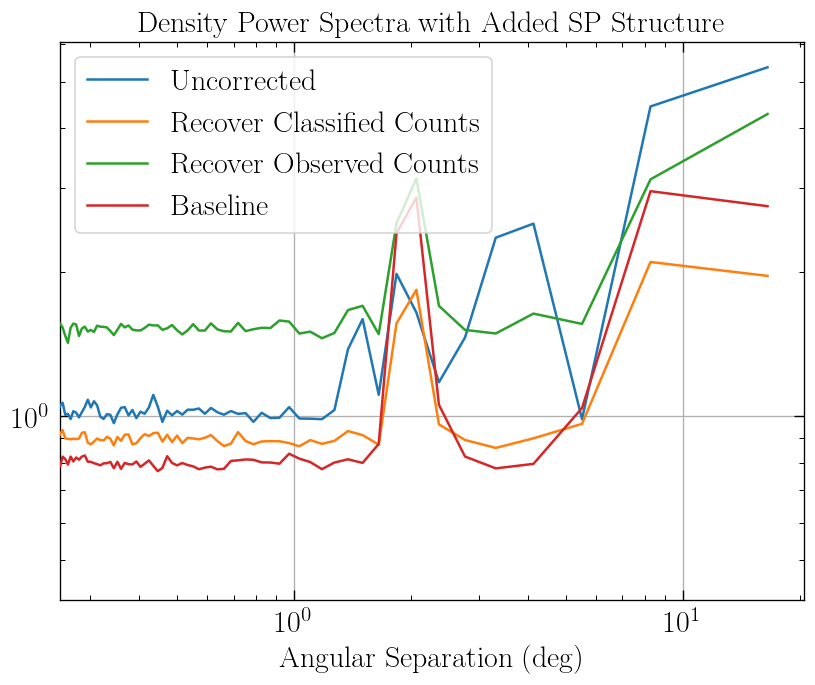

In [76]:
plt.figure(dpi = 120)
plt.plot((180 / np.pi) * (1/f), var_cla_pxx[1], label = 'Uncorrected', zorder = 3)
plt.plot((180 / np.pi) * (1/f), rec_cla_pxx[1], label = 'Recover Classified Counts', zorder = 3)
plt.plot((180 / np.pi) * (1/f), rec_obs_pxx[1], label = 'Recover Observed Counts', zorder = 3)
plt.plot((180 / np.pi) * (1/f), unif_pxx[1], label = 'Baseline', zorder = 3)
# plt.fill_betweenx(np.array([0.1, 10]), 1.1, color = 'black', alpha = 0.2)
# plt.plot(np.array([1.1, 1.1]), np.array([0.1, 10]), color = 'black', linestyle = '--', label = 'DECam Tile Radius')
plt.xscale("log")
plt.yscale("log")
plt.xlim([0.25, None])
# plt.ylim([0.5, 6])
plt.xlabel('Angular Separation (deg)')
plt.title('Density Power Spectra with Added SP Structure')
plt.grid(zorder = 0)
plt.legend()
plt.show()

In [32]:
smoothSigma = .15 * np.pi / 180

hp_unif = np.full(12*(512**2), hp.UNSEEN)
hp_unif[pix512] = np.median(unif_obs, axis = 0)

hp_rec_cla = np.full(12*(512**2), hp.UNSEEN)
hp_rec_cla[pix512] = np.median(rec_cla, axis = 0)

hp_rec_obs = np.full(12*(512**2), hp.UNSEEN)
hp_rec_obs[pix512] = np.median(rec_obs, axis = 0)

hp_var_cla = np.full(12*(512**2), hp.UNSEEN)
hp_var_cla[pix512] = np.median(var_cla, axis = 0)

smoothingWeights = np.zeros(12*(512**2))
smoothingWeights[np.where(hp_unif > 0)[0]] = 1
smoothingWeights = hp.pixelfunc.reorder(hp.sphtfunc.smoothing(hp.pixelfunc.reorder(smoothingWeights, n2r = True), sigma = smoothSigma), r2n = True)

hp_unif = hp.pixelfunc.reorder(hp.sphtfunc.smoothing(hp.pixelfunc.reorder(hp_unif, n2r = True), sigma = smoothSigma), r2n = True)
hp_unif[np.where(hp_unif > 0)[0]] = hp_unif[np.where(hp_unif > 0)[0]] / smoothingWeights[np.where(hp_unif > 0)[0]]

hp_rec_cla = hp.pixelfunc.reorder(hp.sphtfunc.smoothing(hp.pixelfunc.reorder(hp_rec_cla, n2r = True), sigma = smoothSigma), r2n = True)
hp_rec_cla[np.where(hp_rec_cla > 0)[0]] = hp_rec_cla[np.where(hp_rec_cla > 0)[0]] / smoothingWeights[np.where(hp_rec_cla > 0)[0]]

hp_rec_obs = hp.pixelfunc.reorder(hp.sphtfunc.smoothing(hp.pixelfunc.reorder(hp_rec_obs, n2r = True), sigma = smoothSigma), r2n = True)
hp_rec_obs[np.where(hp_rec_obs > 0)[0]] = hp_rec_obs[np.where(hp_rec_obs > 0)[0]] / smoothingWeights[np.where(hp_rec_obs > 0)[0]]

hp_var_cla = hp.pixelfunc.reorder(hp.sphtfunc.smoothing(hp.pixelfunc.reorder(hp_var_cla, n2r = True), sigma = smoothSigma), r2n = True)
hp_var_cla[np.where(hp_var_cla > 0)[0]] = hp_var_cla[np.where(hp_var_cla > 0)[0]] / smoothingWeights[np.where(hp_var_cla > 0)[0]]

nside_coverage = 32

hsp_unif = hsp.HealSparseMap(nside_coverage=nside_coverage, healpix_map=hp_unif)
hsp_rec_cla = hsp.HealSparseMap(nside_coverage=nside_coverage, healpix_map=hp_rec_cla)
hsp_rec_obs = hsp.HealSparseMap(nside_coverage=nside_coverage, healpix_map=hp_rec_obs)
hsp_var_cla = hsp.HealSparseMap(nside_coverage=nside_coverage, healpix_map=hp_var_cla)

In [41]:
writeFile = '/afs/hep.wisc.edu/home/kkboone/data/temp/SimulatedStreams.fits'
my_table = Table()
my_table['PIX'] = pix512
my_table['UNIF'] = hp_unif[pix512]
my_table['REC_CLA'] = hp_rec_cla[pix512]
my_table['REC_OBS'] = hp_rec_obs[pix512]
my_table['VAR_CLA'] = hp_var_cla[pix512]
my_table.write(writeFile, overwrite = True)

## All Below are Median by Pixel

In [42]:
fig = plt.figure(1, figsize=(8, 6))
ax = fig.add_subplot(111)
sp = skyproj.DESSkyproj(ax=ax)
sp.draw_hspmap(hsp_unif, cmap = 'inferno')
plt.clim(12, 15)
# plt.colorbar(location = 'bottom', label = 'Number of Stars per Pixel', fraction = 0.035)
# fig.suptitle(r'Baseline', y = 1)
plt.show()

RuntimeError: latex was not able to process the following string:
b'$22^{\\\\circ}$'

Here is the full command invocation and its output:

latex -interaction=nonstopmode --halt-on-error --output-directory=tmp38ny8m_z 091db50079e32bd07f4f74b553af4781.tex

This is pdfTeX, Version 3.14159265-2.6-1.40.21 (TeX Live 2020) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(./091db50079e32bd07f4f74b553af4781.tex
LaTeX2e <2020-10-01> patch level 4
L3 programming layer <2021-02-18>
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2020/04/10 v1.4m Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))

! LaTeX Error: File `type1cm.sty' not found.

Type X to quit or <RETURN> to proceed,
or enter new name. (Default extension: sty)

Enter file name: 
! Emergency stop.
<read *> 
         
l.8 \usepackage
               {type1ec}^^M
No pages of output.
Transcript written on tmp38ny8m_z/091db50079e32bd07f4f74b553af4781.log.




<Figure size 800x600 with 2 Axes>

In [23]:
fig = plt.figure(1, figsize=(8, 6))
ax = fig.add_subplot(111)
sp = skyproj.DESSkyproj(ax=ax)
sp.draw_hspmap(hsp_rec_cla, cmap = 'inferno')
plt.clim(20.5, 22.5)
plt.colorbar(location = 'bottom', label = 'Number of Stars per Pixel', fraction = 0.035)
fig.suptitle(r'Recovered Classified', y = 1)
plt.show()

RuntimeError: latex was not able to process the following string:
b'$22^{\\\\circ}$'

Here is the full command invocation and its output:

latex -interaction=nonstopmode --halt-on-error --output-directory=tmpemfve2w4 091db50079e32bd07f4f74b553af4781.tex

This is pdfTeX, Version 3.14159265-2.6-1.40.21 (TeX Live 2020) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(./091db50079e32bd07f4f74b553af4781.tex
LaTeX2e <2020-10-01> patch level 4
L3 programming layer <2021-02-18>
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2020/04/10 v1.4m Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))

! LaTeX Error: File `type1cm.sty' not found.

Type X to quit or <RETURN> to proceed,
or enter new name. (Default extension: sty)

Enter file name: 
! Emergency stop.
<read *> 
         
l.8 \usepackage
               {type1ec}^^M
No pages of output.
Transcript written on tmpemfve2w4/091db50079e32bd07f4f74b553af4781.log.




<Figure size 800x600 with 3 Axes>

In [24]:
fig = plt.figure(1, figsize=(8, 6))
ax = fig.add_subplot(111)
sp = skyproj.DESSkyproj(ax=ax)
sp.draw_hspmap(hsp_rec_obs, cmap = 'inferno')
plt.clim(11, 17)
plt.colorbar(location = 'bottom', label = 'Number of Stars per Pixel', fraction = 0.035)
fig.suptitle(r'Recovered Observed', y = 1)
plt.show()

RuntimeError: latex was not able to process the following string:
b'$22^{\\\\circ}$'

Here is the full command invocation and its output:

latex -interaction=nonstopmode --halt-on-error --output-directory=tmp10c03g_b 091db50079e32bd07f4f74b553af4781.tex

This is pdfTeX, Version 3.14159265-2.6-1.40.21 (TeX Live 2020) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(./091db50079e32bd07f4f74b553af4781.tex
LaTeX2e <2020-10-01> patch level 4
L3 programming layer <2021-02-18>
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2020/04/10 v1.4m Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))

! LaTeX Error: File `type1cm.sty' not found.

Type X to quit or <RETURN> to proceed,
or enter new name. (Default extension: sty)

Enter file name: 
! Emergency stop.
<read *> 
         
l.8 \usepackage
               {type1ec}^^M
No pages of output.
Transcript written on tmp10c03g_b/091db50079e32bd07f4f74b553af4781.log.




<Figure size 800x600 with 3 Axes>

In [25]:
fig = plt.figure(1, figsize=(8, 6))
ax = fig.add_subplot(111)
sp = skyproj.DESSkyproj(ax=ax)
sp.draw_hspmap(hsp_var_cla, cmap = 'inferno')
plt.clim(14, 28)
plt.colorbar(location = 'bottom', label = 'Number of Stars per Pixel', fraction = 0.035)
fig.suptitle(r'Uncorrected', y = 1)
plt.show()

RuntimeError: latex was not able to process the following string:
b'$22^{\\\\circ}$'

Here is the full command invocation and its output:

latex -interaction=nonstopmode --halt-on-error --output-directory=tmp9ekfu3u6 091db50079e32bd07f4f74b553af4781.tex

This is pdfTeX, Version 3.14159265-2.6-1.40.21 (TeX Live 2020) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(./091db50079e32bd07f4f74b553af4781.tex
LaTeX2e <2020-10-01> patch level 4
L3 programming layer <2021-02-18>
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2020/04/10 v1.4m Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))

! LaTeX Error: File `type1cm.sty' not found.

Type X to quit or <RETURN> to proceed,
or enter new name. (Default extension: sty)

Enter file name: 
! Emergency stop.
<read *> 
         
l.8 \usepackage
               {type1ec}^^M
No pages of output.
Transcript written on tmp9ekfu3u6/091db50079e32bd07f4f74b553af4781.log.




<Figure size 800x600 with 3 Axes>